<div style="float:left">
    <h1 style="width:450px">Practical 5: Spatial Data</h1>
    <h2 style="width:450px">Getting to grips with Geo-Data using Geopandas</h2>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

Last week we did some initial processing on the Inside Airbnb listings data, focussing on its *numeric* properties. This week we are going to focus on the *spatial* properties of the data set.

## Preamble

<div class="alert alert-block alert-success"><b>&#128161; Tip</b>: It makes life a lot easier if you gather all of the library import commands and configuration information (here having to do with `matplotlib`) in the first exectuable code block in a notebook or script. That way it's easy for you for others to see what what it is necessary to have installed before getting started!.</div>

In [5]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

## Task 1. Reading Geo-Data

I find GeoPackages to be by far the easiest way to distribute geo-data now: they are a single file (in a database-like format that supports multiple types of data), include the projection information by default, and QGIS can even embed information about rendering style! 

However, we're getting a bit ahead of ourselves; let's start by writing a function (it will be _similar_ to the `get_url` function in `dtools`) to download the file to our hard drive and save it there. That way we don't have to keep downloading it week after week. I've set up the basics, but you'll need to Google [download remote file python](https://www.google.com/search?q=python+download+a+remote+file&rlz=1C5CHFA_enGB917GB917&oq=python+download+a+remote+file). If you're not sure about what something in this function does, I'd suggest that you use `return` statements to short-circuit the processing and `print` statements to output the various variables that I derive (e.g. `print(os.path.split(url.path))` and then add `[-1]` to see what that gives you or `print(url)` to see what that is!).

### Task 1.1: Caching Data Files

I've used the Numpy-style comments here, but the Google-style also look good in this context. See overview of commenting styles [on DataCamp](https://www.datacamp.com/community/tutorials/docstrings-python). My answer uses the Numpy Approach, but all styles answers are acceptable.

<div class="alert alert-block alert-success"><b>&#128161; Tip</b>: Use this as an opportunity to improve your ability to read code and to learn through documentation.</div>

<div class="alert alert-block alert-warning"><b>Difficulty level</b>: Moderate</div>

In [6]:
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

help(cache_data)

Help on function cache_data in module __main__:

cache_data(src: str, dest: str) -> str
    Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.



### Task 1.2: Read Remote Geo-Data

<div class="alert alert-block alert-success"><b>Difficult level</b>: Low, if your function works!</div>

Use the function above to download and cache the GeoPackage files found [on GitHub](https://github.com/jreades/fsds/tree/master/data/src) for Boroughs, Water, and Greenspace, then pass the output of these to GeoPandas. If you have been having trouble downloading files from GitHub, then use the understanding of the function developed above to download the file manually and place it where this function expects to find it!

In [7]:
ddir  = os.path.join('data','geo') # destination directory
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )

print('Done.')

Found data/geo/Boroughs.gpkg locally!
Found data/geo/Water.gpkg locally!
Found data/geo/Greenspace.gpkg locally!
Done.


### Task 1.3: Check the Projection

<div class="alert alert-block alert-success"><b>Difficult level</b>: Low</div>

Check the projection of each GeoDataFrame using a for loop and the `crs` attribute.

In [11]:
for g in [boros,water,green]:
    print(g.crs)

epsg:27700
epsg:27700
epsg:27700


You should see that all three are in the [EPSG:27700 CRS](https://epsg.io/27700) which is a common one for analysis using GB data.

### Task 1.4: Check the Data

<div class="alert alert-block alert-success"><b>Difficult level</b>: Low</div>

We'll see how you control figure-making more effectively later, but for now let's just see what they look like:

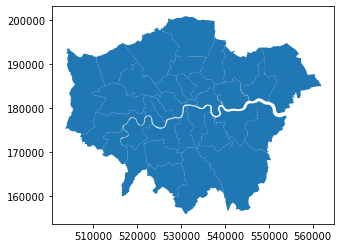

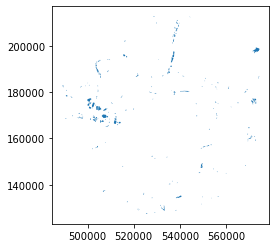

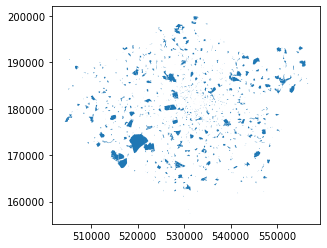

In [12]:
for g in [boros,water,green]:
    g.plot()

## Task 2. An Introduction to Mapping

These files all contain polygons, and the adjustments for points are different, but it's worth seeing how you can tweak these before we start combining them. Behind the scenes, GeoPandas is using `matplotlib` to render the map, so let's play with the colours to get the _start_ of something map-like. 

You will want to look both at [how to make maps in GeoPandas](https://geopandas.org/mapping.html) and  at the different ways to [specify colours in Matplotlib](https://matplotlib.org/3.1.1/tutorials/colors/colors.html#specifying-colors). For the greenspace map you are looking for information about tuples... which can have three or four elements.

### Task 2.1: Work Out the Colour Scheme

<div class="alert alert-block alert-warning"><b>Difficulty level</b>: Moderate</div>

<div class="alert alert-block alert-danger"><b>&#9888; Warning</b>: R and Python take <i>very</i> different approaches to plotting. Do <i>not</i> think of Python's output as being 'maps' in the GIS sense, they are composed of 'patches' of color on abstract 'axes' that can use any arbitrary coordinate space. So colours are 'really' triplet (or quadruplet if you have alpha-blending transparency) values in the range 0.0-1.0. Annotations are then added in similarly abstract fashion.</div>

I'd **suggest** the following colour scheme as a way to test out different ways of specifying colour (though anything you like is fine so long as you manipulate the colours):

- The boroughs can have red edges and white fill with a thick edge.
- The water should have no edges and XKCD Lightblue fill.
- The greenspace should have edges and faces specified using different 'alpha blending' (i.e. transparency) levels.

#### 2.1.1 Boroughs

By way of a hint, matplotlib uses `edgecolor` and `facecolor` for controlling 'patches' (which is what polygons are considered), but the thicker-than-default line-width is specified differently (you'll need to look this up). So the intention is:

1. Thick red borough borders, and 
2. White fill colour.

Just to drive home how different this is from R, you can find the answer to question 1 [on the page for bar plots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html).

<AxesSubplot:>

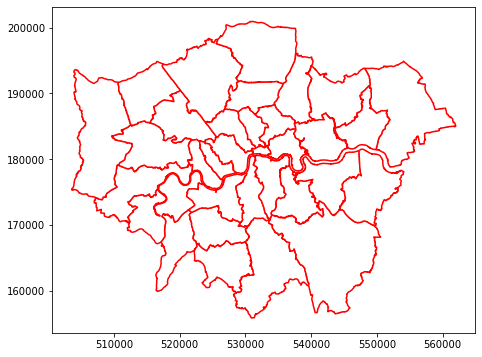

In [16]:
boros.plot(edgecolor='red', facecolor='white', linewidth=1.5, figsize=(8,6))

#### 2.1.2: Water

The process is the same as above, but I'd like you to work out how to specify:
1. _No_ color for an edge, and 
2. An XKCD color for the face.

<AxesSubplot:>

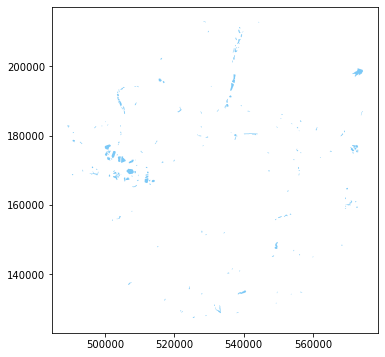

In [17]:
water.plot(edgecolor="none", facecolor='xkcd:lightblue', figsize=(8,6))

#### 2.1.3 Greenspace

The process is _also_ the same as above, but I'd like you to work out how to specify colours and transparency using RGBA (red-green-blue-alpha transparency) tuples. So we're looking for:
1. No edge color.
2. A partially transparent green specified as a 'tuple' (4 numbers in parentheses in the range 0.0-1.0).

<AxesSubplot:>

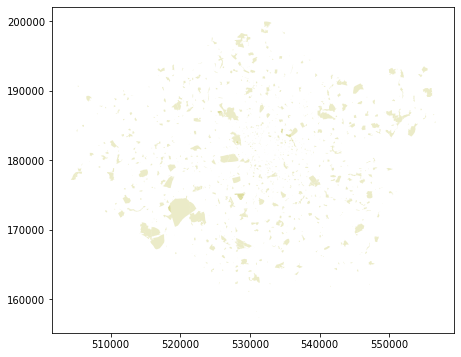

In [18]:
green.plot(edgecolor='none', facecolor=(0.7, 0.7, 0.14, 0.25), figsize=(8,6))

### Task 2.2 Combining Layers

<div class="alert alert-block alert-warning"><b>&#9888; Note</b>: R and Python take <i>very</i> different approaches to plotting. Do <i>not</i> think of Python's output as being 'maps' in the GIS sense, they are composed of 'patches' of color on abstract 'axes' that can use any arbitrary coordinate space. So colours are 'really' numerical triplets (or quadruplets if you have transparency as well) in the range 0.0-1.0. Annotations are then added in similarly abstract fashion.</div>

Now that we've got our layers looking roughly how we want them, it's time to combine them. This is also reliant on `matplotlib` and basically involves plotting items to _shared axes_ which is done by passing in `ax=<axis object>` to each `plot(...)`. By convention, if you only have a single figure (e.g. a single map) then you create an axis object and name it `ax` so you will see a lot of `ax=ax` code in graphing libraries, but `=ax` is just saying 'assign to the axis object that I created'.

Since the axes are how you control what is shown, see if you can find out by Googling how to set the x- and y-limits on the map so that it shows only London and trims out the much larger area of water that is outside of the Greater London Authority. **As a rough guideline, this has the Easting range 501,000 to 563,000, and the Northing range 155,000 to 202,000.**

You can set these limits before or after you start adding layers to the 'map', but it's probably easier conceptually to add them after with the idea of 'zooming in' on the features of interest. It's also easier to debug since you can start by seeing if you can plot the elements at all, and _then_ add the limits to zoom.

**So the steps are:**
1. Write the code to plot every image on the same set of axes (I've given you something to get started).
2. Google how to set the limits of the map and then use the ranges I've offered above.
3. Work out how to change the width of the edges for the boroughs layer. 
4. Save it somewhere local so that you could, say, load it into a Markdown file!

<div class="alert alert-block alert-success"><b>&#128161; Hint</b>: This is a first pass at a map, over the next few weeks we'll see how to add things like axis labels and titles to make it more 'map-like'. We don't have quite the built-in functionality of `ggplot` alas, but Python is advancing very quickly in this area. There is even <a href="https://github.com/yhat/ggpy">an implementation of ggplot in Python</a>, but it's functionality is more limited. In fact, there's <a href="https://github.com/has2k1/plotnine">more than one</a>...</div>

<div class="alert alert-block alert-danger"><b>Difficulty level</b>: Hard</div>

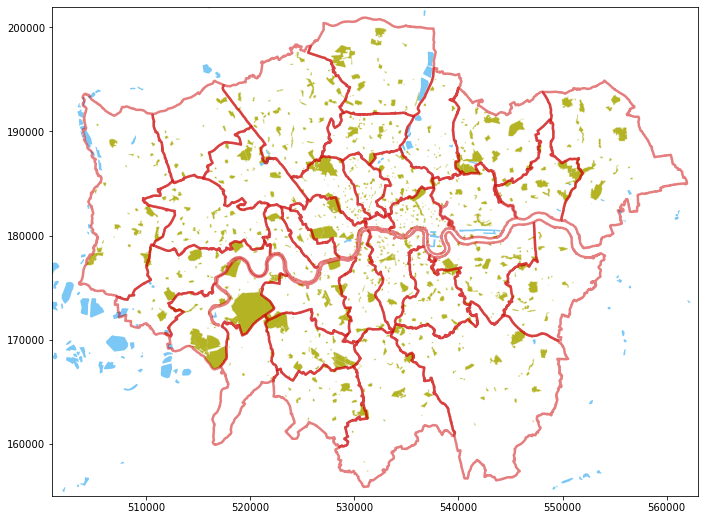

In [20]:
# Creates a new figure with specified number of
# subplots (we'll see more of this later) and 
# and the specified size (in inches by default).
fig, ax = plt.subplots(1,1, figsize=(12,9))

# Plot all three GeoPackages to the same axes
water.plot(edgecolor="none", facecolor='xkcd:lightblue', ax=ax)
green.plot(edgecolor=(0.7, 0.7, 0.14, 0.25), facecolor=(0.7, 0.7, 0.14), ax=ax)
boros.plot(edgecolor=(0.8, 0, 0, 0.5), facecolor='none', linewidth=2.5, ax=ax)

# Set the x and y limits
ax.set_xlim(501000,563000)
ax.set_ylim(155000,202000)

# Save the image (dpi is 'dots per inch')
os.makedirs('img')
plt.savefig(os.path.join('img','My_First_Map.png'), dpi=150)

You may wish for a different look, but here's one version of the output:

![](https://github.com/jreades/i2p/raw/master/practicals/img/Map-First_Pass.png)

## Task 3. 'Creating' Geo-Data

Of course, you will also often encounter geo-data that is not yet 'geographically enabled'; the two most frequent contexts for this are:

1. The data represents points and is provided with latitude and longitude (or similar) as separate columns in a non-geographic data set.
2. The data represents polygons but is provided _separately_ from the polygons themselves and so cannot be shown on a map without being 'joined' to the geography first.

We'll tackle each of these eventually, but for now we're going to focus on the first option.

### Task 3.1: Feather to Pandas

Let's re-use our `cache_data` function to download and save the full Inside Airbnb data set. Again, if you have trouble with downloading via code, use your understanding of the function to work out where to save your own copy of this file so that the function works as expected.

<div class="alert alert-block alert-success"><b>Difficulty level</b>: Low</div>

In [10]:
# Set download URL
host = 'https://orca.casa.ucl.ac.uk'
path = '~jreades/data/'
fn   = '2022-09-10-listings.feather'
url  = f'{host}/{path}/{fn}'

# your code here
df = pd.read_feather( cache_data(url, os.path.join('data','raw')) )
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Found data/raw/2022-09-10-listings.feather locally!
Data frame is 68,741 x 32


This should print out:
```
Data frame is 68,741 x 32
```

### Task 3.2: Checking Lat/Long

Before we mindlessly convert the data it might make sense to sanity-check the data. In GeoPandas we have a `total_bounds` method that gives us the bounding box for a GeoSeries, but how would we do that in Pandas?

<div class="alert alert-block alert-success"><b>&#128161; Hint</b>: Think about what the 'total bounds' (or 'envelope') of a point data set is. You have already seen the pandas functions you'll need to <em>find</em> these...</div>

<div class="alert alert-block alert-warning"><b>Difficulty Level</b>: Moderate</div>

In [11]:
print(f"The bottom-left corner is {df.longitude.min()}, {df.latitude.min()}")
print(f"The top-right corner is {df.longitude.max()}, {df.latitude.max()}")

The bottom-left corner is -0.5236, 51.27248
The top-right corner is 0.30515, 51.70893


Your answer should be something like:
```
The bottom-left corner is -0.5236, 51.27248
The top-right corner is 0.30515, 51.70893
```

### Task 3.4: Embedding Web Maps

<div class="alert alert-block alert-danger"><b>Difficulty Level</b>: Hard</div>

This is more for the sake of demonstrating Python's features than because it's part of my workflow, but what the heck, let's do it! We will create and embed a zoomable web map in the notebook; to do _that_ we need to:

1. Calculate the bounds of the map using the min/max x and y coordinates above.
2. Calculate the centroid of the map from the bounds.
3. Set an appropriate zoom level.

If your work is going well, perhaps you may also want to experiment with [different basemaps](https://ipyleaflet.readthedocs.io/en/latest/api_reference/basemaps.html).

<div class="alert alert-block alert-success"><b>&#128161; Hint</b>: : You can't use <tt>round</tt> here because it it could round up or down depending on what's closest and, consequently, cut off data on your map. So you'll have to look for two <i>other</i> functions that do this predictably (e.g. always rounding down, even if the value is 4.999999). However, those functions don't handle decimals like <tt>round</tt> does, so you need to think about how you could turn a number like 4.99 into a number that those functions <i>can</i> work with and then turn it <i>back</i> into the decimal...</div>

In [12]:
from math import floor, ceil

# Calculate min and max to *two* decimal places
xmin = floor(df.longitude.min()*100)/100
xmax = ceil(df.longitude.max()*100)/100
ymin = floor(df.latitude.min()*100)/100
ymax = ceil(df.latitude.max()*100)/100

# Print them to *3* decimal places to check they end in 0
print(f"{xmin:.3f}, {xmax:.3f}, {ymin:.3f}, {ymax:.3f}")

# Calculate the centre of the map
yctr = ymin+(ymax-ymin)/2
xctr = xmin+(xmax-xmin)/2

# Print this two ways to see an intriguing issue
print(f"{xctr:.5f}, {yctr:.5f}")
print(xctr, yctr)

-0.530, 0.310, 51.270, 51.710
-0.11000, 51.49000
-0.10999999999999999 51.49


You should end up with something like: 
```
-0.530, 0.310, 51.270, 51.710
-0.11000, 51.49000
-0.10999999999999999 51.49
```
You'll see *why* this happens in the answer notebook.

#### 3.4.1 A Note on Floating Points

If you look closely you might see something a little strange here: we have finite input lat/long coordinates but an 'inifite' output centroid. What's up with that? This is one of those subtle issues that can lead to spacecraft or servers crashing and is tied to [issues in floating point arithmetic](https://docs.python.org/3/tutorial/floatingpoint.html#representation-error). If you really need precision then you're better off doing this:

In [13]:
print("These don't necessarily give the same answer...")
print((xmin+xmax)/2)
print(xmin+(xmax-xmin)/2)

print()

from decimal import Decimal
xmax2 = Decimal("0.29")
xmin2 = Decimal("-0.5")

print("These always give the same answer...")
print((xmin2+xmax2)/2)
print(xmin2+(xmax2-xmin2)/2)

These don't necessarily give the same answer...
-0.11000000000000001
-0.10999999999999999

These always give the same answer...
-0.105
-0.105


Obviously we're probably not _too_ concerned about getting it _exactly_ right when we just want to centre an interactive map on a whole region, but for some types of calculatings this is going to matter a great deal, and if the output of one calculation is the input to another then the issue could compound and become [quite significant indeed](https://stackoverflow.com/questions/2732845/real-life-example-fo-floating-point-error). There's an old story (probably true) of the programmer for a bank who collected the fractional interest payments generated by the use of floating point numbers (where the bank should have been using fixed decimals) and walked away with several million dollars. It became part of the [plot of a comedy film](https://en.wikipedia.org/wiki/Office_Space).

If you've managed the calculations above, then the code below should simply run!

In [14]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, Rectangle, projections

# Note the basemap can be easily changed
watercolor = basemap_to_tiles(basemaps.Stamen.Watercolor)

m = Map(layers=(watercolor, ), center=(yctr, xctr), zoom=8)

rectangle = Rectangle(bounds=( (ymin, xmin), (ymax, xmax) ),
    crs=projections.EPSG4326
)

m.add_layer(rectangle)

m

Map(center=[51.49, -0.10999999999999999], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_…

Your map should look like this:

![](https://github.com/jreades/i2p/raw/master/practicals/img/Stamen.png)

### Task 3.5: Lat/Long to GeoSeries

<div class="alert alert-block alert-success"><b>Difficulty Level</b>: Low</div>

Right, we're finally there! We need to convert our coordinates into some kind of geo-data. GeoPandas offers two ways to do this: the original way using `zip` and a new utility method called `points_from_xy`. Here's the old way:
```python
from shapely.geometry import Point
gdf = gpd.GeoDataFrame(df, 
                geometry=[Point(x,y) for x, y in zip(df.Longitude,df.Latitude)])
```
Note, however, that this did not automatically set a projection, unlike the new approach with the 'helper function':

In [15]:
gdf = gpd.GeoDataFrame(df, 
      geometry=gpd.points_from_xy(df.longitude, df.latitude, crs='epsg:4326'))

In [29]:
print(type(gdf))
print(type(gdf.geometry))

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geoseries.GeoSeries'>


### Task 3.6: Plotting

<div class="alert alert-block alert-success"><b>Difficulty Level</b>: Low</div>

Now that we've converted the InsideAirbnb data to a GeoDataFrame, we can plot it, reproject it, etc.

See if you can work out how to plot the points coloured by their price using the appropriate BNG projection.

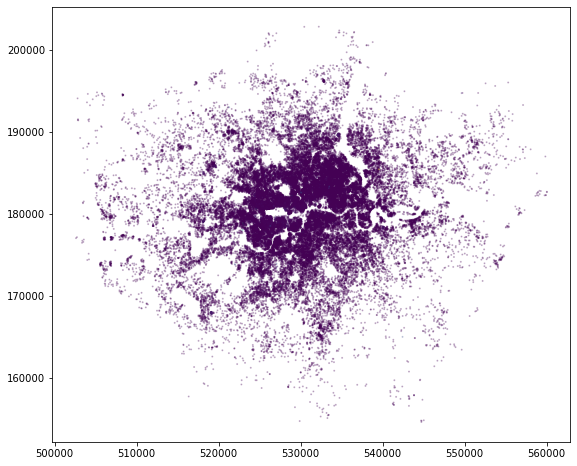

In [31]:
gdf.to_crs('epsg:27700').plot(column='price', cmap='viridis', alpha=0.25, markersize=1, figsize=(12,8));

Using the Viridis colourmap I get the following:

![Viridis Chloropleth Map of InsideAirbnb Listings](https://github.com/jreades/fsds/raw/master/practicals/img/Viridis.png)

### Task 3.7: Saving Geo-Data Locally

<div class="alert alert-block alert-success"><b>Difficulty Level</b>: Low</div>

Since there are _many_ formats in which to save geo-data, rather than have multiple `to_format_x` methods, GeoPandas has _one_ for local files (`to_file`). If you are reading/writing a filename than ends in a valid extension (e.g. `.shp`, `.gpkg`, or `.geojson`) then GeoPandas will 'do the right thing'. Where you *may* run into trouble is if you are reading/writing a **URL** (e.g. [https://github.com/jreades/fsds/blob/master/data/src/Boroughs.gpkg**?raw=true**](https://github.com/jreades/fsds/blob/master/data/src/Boroughs.gpkg?raw=true)). With this URL ending in `?raw=true` there's no extension that GeoPandas can read so you *will* need to specify a driver. If in doubt, specify the driver as below:

<div class="alert alert-block alert-info"><b>Clarification</b>: in this example we are reading from GitHub and I'm saying that we need to specify the driver. So why didn't we need to do with the <tt>cache_data</tt> function earlier as well? Well, this was a side-benefit of using the standard URL library: it <i>automatically</i> stripped off the query string (<tt>?raw=true</tt>) when I asked it for the file name, so we saved the file locally as a GeoPackage with <tt>.gpkg</tt> extension, which means that GeoPandas could read it without any problems.</div>

So the following two bits of code are equivalent:

In [17]:
boros.to_file('test.gpkg') # This *may* not always do what we want, but should be fine for local files

In [18]:
boros.to_file('test.gpkg', driver='GPKG') # This is safer if working across computers/the Internet

Now save the InsideAirbnb GeoDataFrame to the 'geo' directory, but first let's see [what file formats are supported](https://geopandas.org/en/stable/docs/user_guide/io.html):

In [21]:
import fiona; fiona.supported_drivers # But GeoPandas also directly supports feather and parquet

{'DXF': 'rw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'FlatGeobuf': 'rw',
 'GeoJSON': 'raw',
 'GeoJSONSeq': 'rw',
 'GPKG': 'raw',
 'GML': 'rw',
 'OGR_GMT': 'rw',
 'GPX': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'raw',
 'OGR_PDS': 'r',
 'S57': 'r',
 'SQLite': 'raw',
 'TopoJSON': 'r'}

So we have two options:

- File formats with wider compatibility (the ones supported by Fiona) may not be fully-compatible with the Pandas/GeoPandas data formats. For example, **Categorical Data** is not supported by any standard format, and Shapefiles don't reliably support column labels (`df.columns`) longer than 10 characters!
- File formats with Python compatibility and performance benefits are much less likely to be compatible with a GIS. So for these we have to write them `to_feather` and `read_feather`, and `to_parquet` and `read_parquet`.

Notice the difference:

In [34]:
print(f"Using '{fn}' as basis for saving data...")
gdf.to_file(os.path.join('data','geo',fn.replace('.feather','.gpkg')), driver='GPKG')

Using '2022-09-10-listings.feather' as basis for saving data...


TypeError: Cannot interpret 'CategoricalDtype(categories=['Barn', 'Boat', 'Bus', 'Camper/RV', 'Campsite',
                  'Casa particular', 'Castle', 'Dome', 'Earthen home',
                  'Entire bungalow', 'Entire cabin', 'Entire chalet',
                  'Entire condo', 'Entire cottage', 'Entire guest suite',
                  'Entire guesthouse', 'Entire home', 'Entire home/apt',
                  'Entire loft', 'Entire place', 'Entire rental unit',
                  'Entire serviced apartment', 'Entire townhouse',
                  'Entire vacation home', 'Entire villa', 'Floor', 'Houseboat',
                  'Hut', 'Island', 'Minsu', 'Private room',
                  'Private room in bed and breakfast', 'Private room in boat',
                  'Private room in bungalow', 'Private room in cabin',
                  'Private room in camper/rv',
                  'Private room in casa particular', 'Private room in castle',
                  'Private room in chalet', 'Private room in condo',
                  'Private room in cottage', 'Private room in earthen home',
                  'Private room in farm stay', 'Private room in floor',
                  'Private room in guest suite', 'Private room in guesthouse',
                  'Private room in home', 'Private room in hostel',
                  'Private room in houseboat', 'Private room in hut',
                  'Private room in island', 'Private room in lighthouse',
                  'Private room in loft', 'Private room in nature lodge',
                  'Private room in parking space',
                  'Private room in religious building',
                  'Private room in rental unit',
                  'Private room in serviced apartment',
                  'Private room in shepherd's hut',
                  'Private room in tiny home', 'Private room in tipi',
                  'Private room in townhouse', 'Private room in treehouse',
                  'Private room in vacation home', 'Private room in villa',
                  'Private room in yurt', 'Religious building', 'Riad',
                  'Room in aparthotel', 'Room in bed and breakfast',
                  'Room in boutique hotel', 'Room in hostel', 'Room in hotel',
                  'Room in rental unit', 'Room in serviced apartment',
                  'Shared room', 'Shared room in bed and breakfast',
                  'Shared room in boutique hotel', 'Shared room in bungalow',
                  'Shared room in bus', 'Shared room in condo',
                  'Shared room in earthen home', 'Shared room in farm stay',
                  'Shared room in guest suite', 'Shared room in guesthouse',
                  'Shared room in home', 'Shared room in hostel',
                  'Shared room in hotel', 'Shared room in loft',
                  'Shared room in rental unit',
                  'Shared room in serviced apartment',
                  'Shared room in townhouse', 'Shared room in vacation home',
                  'Shared room in villa', 'Shepherd’s hut', 'Tent',
                  'Tiny home', 'Tower', 'Treehouse', 'Yurt'],
, ordered=False)' as a data type

The above throws a `TypeError` because of the presence of Categorical data.

But the below, which we specify as a 'geofeather' because of the coordinate data, does not:

In [36]:
print(f"Using '{fn}' as basis for saving data...")
gdf.to_feather(os.path.join('data','geo',fn.replace('.feather','.geofeather')))

Using '2022-09-10-listings.feather' as basis for saving data...


### Task 3.8: Compare

It's also worth comparing the output of a point with the output of a polygon or multi-polygon because you may well come across data in formats (e.g. WKT) resembling both of these in real data sets and they *can* be read as well. Notice too that we can use `loc` and `iloc` accessor methods to pull individual points and polygons out of a GeoDataFrame!

POINT (-0.16813 51.4878)


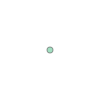

In [41]:
print(gdf.geometry.iloc[1]) # Print out the object's contents
gdf.geometry.iloc[1] # The object knows how to print itself as a point

MULTIPOLYGON (((535009.2 159504.7, 535005.5 159502, 535002.9 159500.1, 535000.1 159503.2, 535000 159503.2, 534747.8 159517.8, 534588 159522.1, 534512.3 159780.5, 534474.8 159760.8, 534398.8 159726.7, 534391.9 159723.3, 534378.9 159712.4, 534345.1 159702.8, 534314.3 159691.8, 534292.7 159683.9, 534253.1 159666.6, 534229.4 159657.9, 534207.5 159654.6, 534160.5 159651.5, 534159.7 159637.1, 534109.5 ...


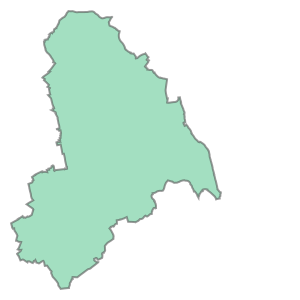

In [39]:
print(str(boros.geometry.iloc[1])[:399] + "...") # Object to string then print out first 399 characters
boros.geometry.iloc[1] # So this is a multi-polygon boundary

So each element of this Series has text indicating the type of shape the geometry applies to (e.g. _POLYGON_) followed by a bunch of numbers. These numbers are truncated here just to make things a little more legible.

## Task 4. Dealing with (Geo)Data

Let's dig a little deeper into GeoPandas' features.

### Task 4.1: Reprojection

<div class="alert alert-block alert-success"><b>Difficulty Level</b>: Low</div>

Let's start by taking our InsideAirbnb data in its original projection...

In [42]:
print(gdf.geometry.crs)
print(gdf.total_bounds)

epsg:4326
[-0.5236  51.27248  0.30515 51.70893]


... and reprojecting this into the OSGB1936/BNG CRS:

In [44]:
gdf = gdf.to_crs('epsg:27700') # There is no 'in_place=True' option here.
print(gdf.geometry.crs)
print(gdf.total_bounds)

epsg:27700
[502615.87511762 154633.50599878 560027.49389306 202832.88761803]


Notice the change in total bounds from lat/long to Northing/Easting.

### Task 4.2: More on Mapping

<div class="alert alert-block alert-success"><b>Difficulty Level</b>: Low</div>

As we saw above with the point-plot, in its original form the pricing data will not reveal much of interest because of the range of the data. However, as you will have seen in QM already (and as we explore in greater detail in Weeks 7/8), using *transformations* we can manipulate the data to increase its tractability for analysis.

#### 4.2.1 Work out the Data Range

Let's start by getting a feel for the full data set in terms of the range of prices that it contains:

In [45]:
print(f"The range of price is ${gdf.price.min():,.2f} to ${gdf.price.max():,.2f}")
print(f"The mean and median of the price are ${gdf.price.mean():,.2f} and ${gdf.price.median():,.2f}")

The range of price is $0.00 to $25,000.00
The mean and median of the price are $177.45 and $100.00


Notice the neat little comma-separated thousands in there? That's fairly easy to do in English, but to use a thousands separator common to another language you would need to do something [a little more tricky](https://stackoverflow.com/questions/13082620/how-can-i-print-a-float-with-thousands-separators). 

#### 4.2.2: Inheritance!

We already know that GeoPandas _inherits_ functionality from Pandas, but let's formalise this... 

First, let's check what class of object `gdf` is using the [`isinstance`](https://www.w3schools.com/python/ref_func_isinstance.asp) function:

In [73]:
if isinstance(gdf, gpd.GeoDataFrame): # Is gdf a GeoDataFrame object?
    print("\tI'm a geopandas data frame!")

if isinstance(gdf, pd.DataFrame): # Is gdf *also* a DataFrame object?
    print("\tI'm a pandas data frame!")

	I'm a geopandas data frame!
	I'm also a pandas data frame!


#### 4.2.3 Benefiting from Inheritance

*That* result means that we can also investigate the data using, for instance, a pandas histogram:

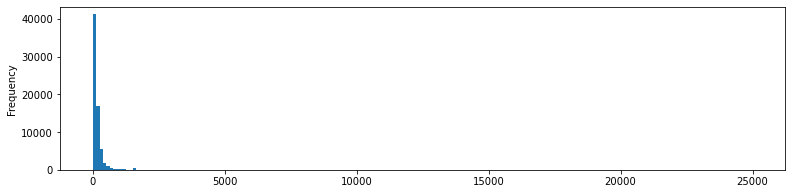

In [47]:
gdf.price.plot.hist(bins=200, figsize=(13,3)); # Oooooh, let's use a *pandas* method here

Notice how we've used our GeoDataFrame *as if* it's a plain old DataFrame here? That's the miracle of Object-Oriented Design: we can do *anything* we would with a regular Pandas `df` as we do with a GeoPandas `gdf` because GeoPandas *inherits* all the methods of its parent super-class.

We can see that there's very little data above (at a guess) about $2,000, but at this scale it's hard to tell. We've already seen that you can use axes limits to adjust the display of a map, but the same technique applies to plain old plots because they're fundamentally the *same thing*.

Try adjusting the axis so that the x-range is 0..2500:

(0.0, 2500.0)

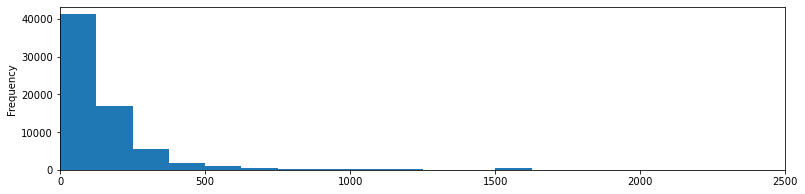

In [48]:
ax = gdf.price.plot.hist(bins=200, figsize=(13,3)); # Oooooh, let's use a *pandas* method here
ax.set_xlim(0,2500)

You can do the same thing with a boxplot:

(0.0, 2500.0)

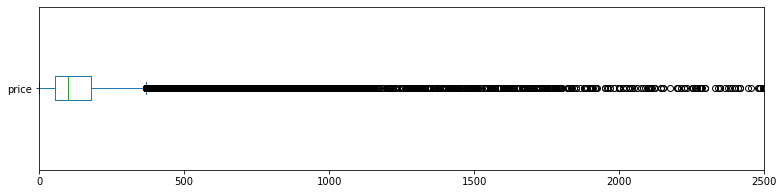

In [56]:
ax = gdf.price.plot.box(vert=False, figsize=(13,3))
ax.set_xlim(0,2500)

[More complex](https://stackoverflow.com/a/54023612/4041902) formatting is also possible if you really know your pandas and your matplotlib:

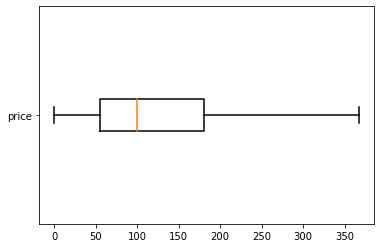

In [58]:
gdf.price.plot(kind='box', vert=False, 
             color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
             boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(linestyle='-', linewidth=1.5),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=False, grid=False, rot=0);

### Task 4.3: Truncating and Transforming

<div class="alert alert-block alert-danger"><b>Difficulty Level</b>: Hard</div>

#### 4.3.1 Working it Out

Anyway, drawing on everything we've seen over the past couple of weeks (and in *this* practical) I'd like you to:

1. Try to take the natural-log of the price (*hint*: use `numpy`) and assign to a new Series called `lnprice`.
2. Work out what the error means.
3. Work out how to fix the error and *then* repeate step 1.
4. Work out how many rows were affected.
5. Report on the new min/max values.
6. Work out if other outliers need to be removed (use code from above).
7. Remove outliers and then continue with your work...

gdf has 68,735 rows.
gdf now has 67,442 rows.
The range of price is 7.00 to 1,000.00
The range of ln(price) is 1.9459 to 6.9078


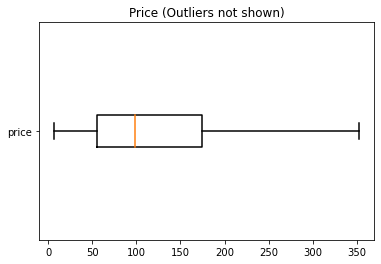

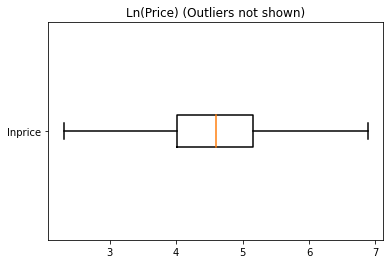

In [65]:
print(f"gdf has {gdf.shape[0]:,.0f} rows.")
gdf.drop(gdf[gdf.price==0].index, axis=0, inplace=True)
gdf.drop(gdf[gdf.price < 5].index, axis=0, inplace=True)
gdf.drop(gdf[gdf.price > 1000].index, axis=0, inplace=True)
gdf['lnprice'] = np.log(gdf.price)
print(f"gdf now has {gdf.shape[0]:,.0f} rows.")
print(f"The range of price is {gdf.price.min():,.2f} to {gdf.price.max():,.2f}")
print(f"The range of ln(price) is {gdf.lnprice.min():,.4f} to {gdf.lnprice.max():,.4f}")
gdf.price.plot(kind='box', vert=False, 
             color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
             boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(linestyle='-', linewidth=1.5),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=False, grid=False, rot=0);
plt.title("Price (Outliers not shown)")
plt.show()
gdf.lnprice.plot(kind='box', vert=False, 
             color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
             boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(linestyle='-', linewidth=1.5),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=False, grid=False, rot=0);
plt.title("Ln(Price) (Outliers not shown)")
plt.show()

In my case (not rigorously worked out), I ended up with about 67,442 rows after removing extreme high/low values from the data using a lower threshold of \\$7.00/night and upper threshold of \\$1,000/night. That gave me:

```
The range of price is 7.00 to 1,000.00
The range of ln(price) is 1.9459 to 6.9078
```

#### 4.3.2 Plotting

Now plot the ln(price) as a choropleth using:
1. A figure size of 12 x 8
2. A marker size of 0.25
3. The Viridis colourmap
4. A legend
5. A legend label of 'Natural Log of Price per Night ($)'

I'd suggest [referring to the documentation](https://geopandas.org/mapping.html).

Text(0.5, 1.0, 'Plot of Natural Log of Nightly Price for Airbnb Listings (Outliers Removed)')

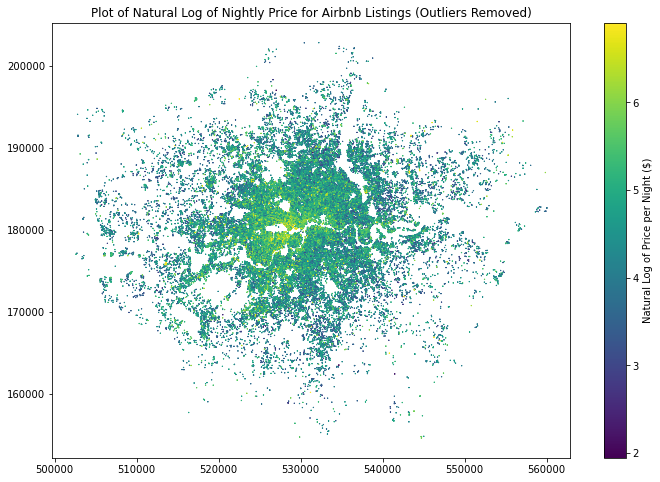

In [68]:
ax = gdf.plot(figsize=(12,8), marker='*', markersize=0.25, 
         column='lnprice', cmap='viridis', 
         legend=True, legend_kwds={'label':'Natural Log of Price per Night ($)'});
ax.set_title("Plot of Natural Log of Nightly Price for Airbnb Listings (Outliers Removed)");

Your map should look something like this:
    
![Plot of Natural Log of Nightly Price for Airbnb Listings (Outliers Removed)](https://github.com/jreades/fsds/raw/master/practicals/img/Airbnb-lnprice.png)

### Task 4.4: Zooming In/Out

<div class="alert alert-block alert-success"><b>Difficulty Level</b>: Low</div>

That's a little hard to see, let's try zooming in on Central London! Very roughly, let's call that an Easting range of 525,000 to 535,000 and a Northing range of 178,000 to 185,000.

<div class="alert alert-block alert-success"><b>&#128161; Hint</b>: You will need to remember that <tt>GeoDataFrame.plot()</tt> returns an axis object.</div>

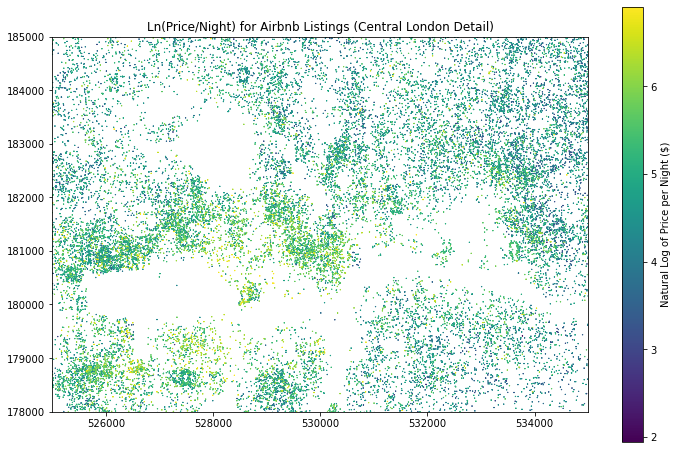

In [72]:
ax = gdf.plot(figsize=(12,8), marker='*', markersize=0.25, 
         column='lnprice', cmap='viridis', 
         legend=True, legend_kwds={'label':'Natural Log of Price per Night ($)'});
ax.set_title("Ln(Price/Night) for Airbnb Listings (Central London Detail)")
ax.set_xlim([525000,535000])
ax.set_ylim([178000,185000]);

You result should look something like this:

![Ln(Price/Night) for Airbnb Listings (Central London Detail)](https://github.com/jreades/fsds/raw/master/practicals/img/Airbnb-lnprice-zoom.png)

That's a little better, but ideally we'd do more thinking about outliers... 

### Task 4.5: Changing the Classification Scheme

<div class="alert alert-block alert-warning"><b>Difficulty Level</b>: Moderate (mainly computation time)</div>

Let's give this one last try using a different classification scheme... such as Fisher-Jenks... for Central London!

(178000.0, 185000.0)

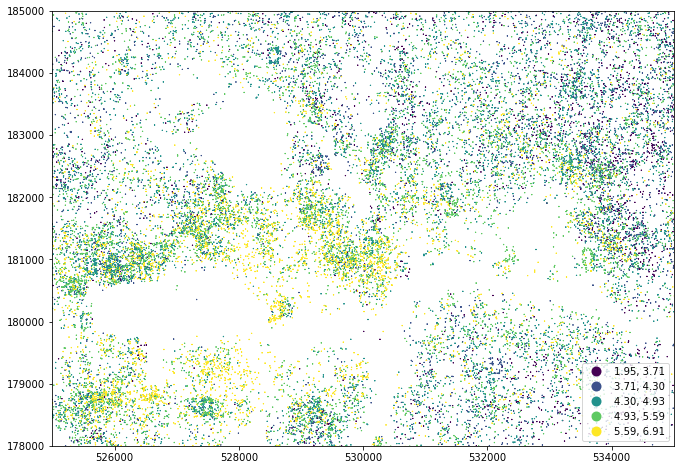

In [74]:
ax = gdf.plot(figsize=(12,8), marker='*', markersize=0.25, 
         column='lnprice', cmap='viridis', scheme='fisher_jenks', k=5, 
         legend=True); # Note that the legend *label* had to go -- there are other ways to add it

ax.set_xlim([525000,535000])
ax.set_ylim([178000,185000])

### Task 4.6: Bringing it All Together

<div class="alert alert-block alert-danger"><b>Difficulty Level</b>: &#129327;</div>

And just to give a bit of a show of how we can put it all together:

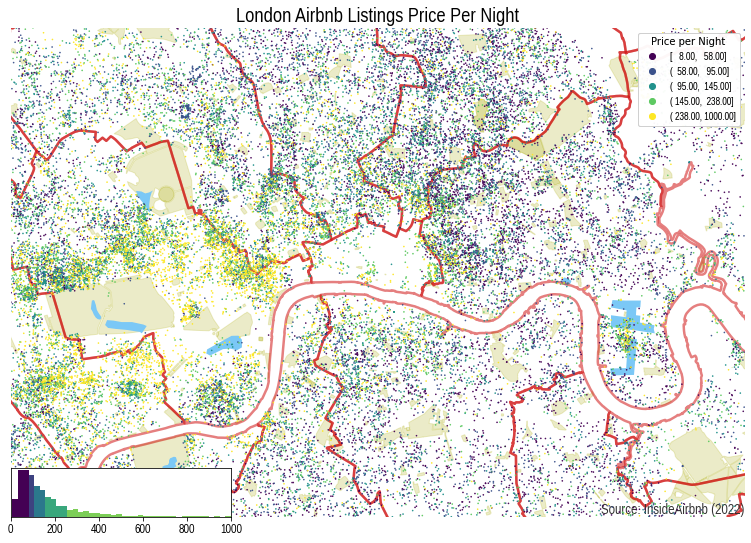

In [150]:
import pysal as p
import mapclassify as mc
import palettable.matplotlib as palmpl
from legendgram import legendgram

# We change fonts the hard way here...
# but you can also do this to change
# the font everywhere in one go:
# matplotlib.rcParams['font.family'] = "Liberation Sans Narrow"
fontname = "Liberation Sans Narrow"

# We create a temporary data frame here because we want
# the 'bins' to be created using only the data on the 
# map. Otherwise, we'd have a distribution on the map 
# that differed from the one in the legendgram and the
# one used to calculate the breaks in the first place!
tgdf = gdf[(gdf.geometry.x > 525000) & (gdf.geometry.x < 540000) & (gdf.geometry.y > 176000) & (gdf.geometry.y < 186000)].copy()

# Here we use Mapclassify to calculate quantiles
# (k=5) using the original price. You could use
# any Mapclassify scheme at this point, though
# note that for Fisher Jenks you might want to use
# the 'Sampled' version to speed things up a bit.
q = mc.Quantiles(tgdf.price.values, k=5)

# We then write these binned values *back* on to the data
# frame so that we can use them with the GDF plot function.
tgdf['bins'] = q.yb

# Set up the figure with its 'basemap'
f,ax = plt.subplots(figsize=(15,9))
green.plot(edgecolor=(0.7, 0.7, 0.14, 0.25), facecolor=(0.7, 0.7, 0.14, 0.25), zorder=1, ax=ax)
water.plot(edgecolor="none", facecolor='xkcd:lightblue', zorder=2, ax=ax)
boros.plot(edgecolor=(0.8, 0, 0, 0.5), facecolor='none', linewidth=2.5, zorder=3, ax=ax)

# Restrict the x and y axis to the data
# Notice it's hard-coded here *and* above
# this could be done *better* using a 
# custom bounding box so that we could 
# update both the tgdf and the display
# area at the same time.
ax.set_xlim([525000,540000])
ax.set_ylim([176000,186000])

ax.axis('off') # Don't plot the axes

# Plot the bins using a categorical legend instead
# of the price using a continuous legend.
tgdf.plot(column='bins', categorical=True,
         cmap='viridis', legend=True, marker='.', markersize=1.5, zorder=4, ax=ax)

# Set the title using a specified font, weight, and size
ax.set_title('London Airbnb Listings Price Per Night', 
             fontdict={'fontsize':'20', 'fontweight':'3', 'family':fontname})  #provide a title

# This is where geopandas gets in the way -- the 
# categorical legend doesn't work for us so we need
# to actually create the legend 'by hand' using this 
# code... which first has to *find* the layer containing
# the data! Each layer is a 'patch collection', so we 
# loop through the collections looking for the one whose
# z-order is 4 (which we set above to the data layer).
#
# I relied on this: https://stackoverflow.com/a/71419387/4041902
# to work out how to do this!
for c in ax.collections:
    # Find the layer with the data
    if c.get_zorder()==4:
        # *Now* we can create a legend... but we need to 
        # first retrieve the colours from the layer. These
        # are returned as 'handles' and then we need to 
        # associate these with the labels taken from the
        # Mapclassify object... Once we set that up, along
        # with fonts and such, we can add it as an 'artist'
        # to the figure.
        handles, _ = c.legend_elements(prop="colors")
        legend1 = ax.legend(handles, q.get_legend_classes(fmt='{:.2f}'), 
                            loc="upper right", title="Price per Night", 
                            prop={'size':'10', 'weight':'1', 'family':fontname})
        ax.add_artist(legend1)

# And don't forget to add a source!
a = ax.text(tgdf.geometry.x.max(), tgdf.geometry.y.min(), 'Source: InsideAirbnb (2022)', 
             horizontalalignment='right', verticalalignment='bottom', 
             fontsize=14, fontweight=4, color='#333333', family=fontname)

# And this is a nice feature: show the distribution!
ax2 = legendgram(f, ax, 
           tgdf.price, q.bins, bins=round(gdf.price.max()/25),
           pal=palmpl.Viridis_5,
           legend_size=(0.3, 0.1), 
           loc='lower left',
           clip=(0,1000),
           frameon=True
    )
# But we have to fix the font manually here
# for the legendgram too
for tk in ax2.get_xticklabels():
    tk.set_fontname(fontname)
    
#plt.savefig('Airbnb-price-all.png', dpi=150)

You should have something like this:
    
![London Airbnb Listings Price Per Night (Quantiles)](https://github.com/jreades/fsds/raw/master/practicals/img/Airbnb-price-all-together.png)

I'll be honest, I do find ggplot easier for making good-quality; this _is_ more customisable overall, but it's also much more 'magical' in the sense of 'search for `matplotlib` examples that do what you want then copy+paste them and tweak' being the main way that most people get things working how they want.

Scalebars are awkward, and there's now a library that can help with this [on GitHub](https://github.com/ppinard/matplotlib-scalebar) that I've installed. But I'll leave that one to you.

<div class="alert alert-block alert-success"><b>&#128161; Tip</b>: You can find a lot of _possible_ solutions in <a href="https://stackoverflow.com/questions/32333870/how-can-i-show-a-km-ruler-on-a-cartopy-matplotlib-plot">this Stackoverflow thread</a> that <i>should</i> work without needing to install new libraries but I've not had a chance to test them each individually. You would undoubtedly want to put this in an external package and import it when needed rather than paste this code into every file. But you might find it easier to <i>test</i> the solutions by pasting. If you're looking for glory (and my gratitude) then working out which of these is most generalisable (i.e. would work with both lat/long <i>and</i> OSGB coordinates) would be quite the challenge!</div>

### Getting More Help/Applications

A great resource for more help and more examples is Dani Arribas-Bel's _Geographic Data Science_ module: he has put all of his [module practicals online](http://darribas.org/gds17/) (as we have too), and you might find that something that he does makes more sense to you than what we've done... check it out!

## Credits!

#### Contributors:
The following individuals have contributed to these teaching materials: Jon Reades (jonathan.reades@kcl.ac.uk), James Millington (james.millington@kcl.ac.uk)

#### License
These teaching materials are licensed under a mix of [The MIT License](https://opensource.org/licenses/mit-license.php) and the [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 license](https://creativecommons.org/licenses/by-nc-sa/4.0/).

#### Acknowledgements:
Supported by the [Royal Geographical Society](https://www.rgs.org/HomePage.htm) (with the Institute of British Geographers) with a Ray Y Gildea Jr Award.

#### Potential Dependencies:
This notebook may depend on the following libraries: pandas, matplotlib, seaborn